In [1]:
import sys
sys.path.append("/home/qrr2/project/")
sys.path.append("/home/qrr2/project/QOGS/")
import numpy as np
from scipy.ndimage import gaussian_filter
import qutip as qt
import matplotlib
import matplotlib.pyplot as plt
import timeit
import csv
import multiprocessing as mp
from matplotlib.colors import TwoSlopeNorm
from datetime import datetime
from functools import partial
from pathlib import Path
from tqdm import tqdm
from scipy.signal import find_peaks
import h5py
matplotlib.get_backend()

'module://matplotlib_inline.backend_inline'

### Parameters

In [2]:
# General
plot = True
fontsize = 12
plt.rcParams.update({'font.size': fontsize})
np.set_printoptions(precision=3)
cm = 1 / 2.54
pi2 = np.pi * 2

# Parameters
target_fock = 3        # Target fock integer
alpha = 190 * pi2      # Transmon anharmonicity
T1q = 20               # In μs
T1p = 100              # In μs
T2q = 1000             # In μs
g1q = 1/T1q            # Qubit decay 
g1p = 1/T1q            # Phonon decay
gphiq = 1/T2q          # Qubit dephasing 
ga = 0.28 * pi2        # In MHz

# System 
dim_qubit = 2        
dim_phonon = 10                                     
Id = qt.tensor(qt.qeye(dim_qubit), qt.qeye(dim_phonon))
q = qt.tensor(qt.destroy(dim_qubit), qt.qeye(dim_phonon))
p = qt.tensor(qt.qeye(dim_qubit), qt.destroy(dim_phonon))
qd = q.dag()
pd = p.dag()

###  Load CSV

In [3]:
file = open("/home/qrr2/project/QOGS/examples/HyQu/OC_Fock_3_v5.csv", "r")
ReOmega = np.array([ [float(row[0])/1000, float(row[1]) ] for row in list(csv.reader(file, delimiter=","))])
file.close()

file = open("/home/qrr2/project/QOGS/examples/HyQu/OC_Fock_3_v5.csv", "r")
ImOmega = np.array([ [float(row[0])/1000, float(row[2]) ] for row in list(csv.reader(file, delimiter=","))])
file.close()

timesFromOC = list(ReOmega[:,0])
T = timesFromOC[-1]                 
nt = len(timesFromOC)                
dt = timesFromOC[1]-timesFromOC[0]   
print(f'dt = {dt * 1e3:.3f}ns')
times_1 = timesFromOC
step = 10

dt = 1.000ns


### Plot Pulse

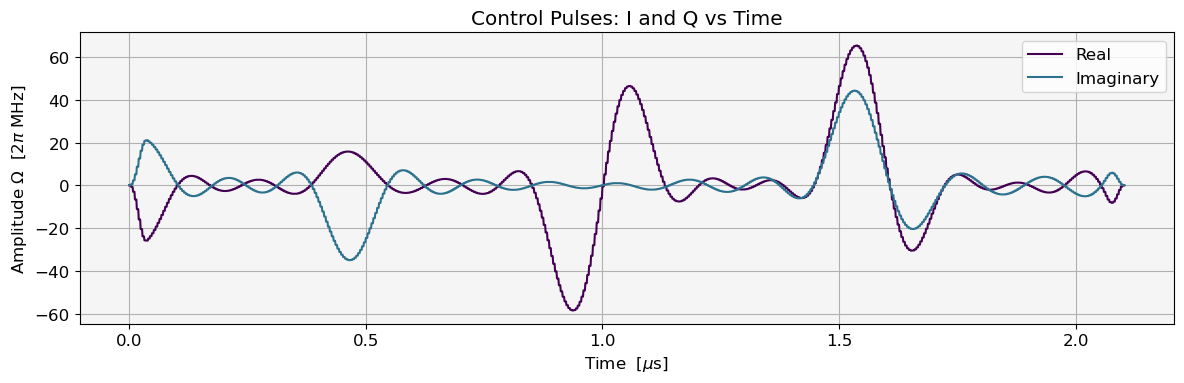

In [4]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_facecolor('whitesmoke')
plt.plot(timesFromOC, ReOmega[:,1], label='Real', color='#440154FF')
plt.plot(timesFromOC, ImOmega[:,1], label='Imaginary', color='#2C728EFF')
plt.xlabel(r"Time  [$\mu$s]")
plt.ylabel('Amplitude $\Omega$  [2$\pi$ MHz]')
plt.title('Control Pulses: I and Q vs Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Function Definitions

In [5]:
def create_hamiltonian(amp):
    Hq = 0 * qd*q - alpha/2 * qd*qd*q*q
    Hph = 0 * pd * p
    Hcoupling = ga * (pd * q + p * qd)
    Hdrive = [[amp * (q + qd), ReOmega[:,1]], [amp * (1j*(q - qd)), ImOmega[:,1]]]
    H = [Hq + Hph + Hcoupling, *Hdrive]
    return H

def simulate_hamiltonian(H,rho0, c_ops = [np.sqrt(g1p) * p, np.sqrt(g1q) * q, np.sqrt(2*gphiq) * qd*q], e_ops = []):
    options = qt.Options(nsteps=500000, atol=1e-8, rtol=1e-6)
    tic = timeit.default_timer()
    res = qt.mesolve(H, rho0, times_1, c_ops=c_ops, e_ops=[], args=None, options=options, progress_bar=True)
    toc = timeit.default_timer()
    print(f'mesolve time: {toc - tic:.1f}s')
    res_rho = res.states
    return res_rho

def compute_dm(res_rho):  
    tt = [ t for t in times_1[::step] ]
    gg = []
    ee = []
    g0 = []
    g1 = []
    e0 = []
    e1 = []
    
    for rho in tqdm(res_rho[::step]):   
        gg.append(qt.expect(qt.tensor((qt.basis(dim_qubit,0)).proj(), qt.qeye(dim_phonon)), rho))
        ee.append(qt.expect(qt.tensor((qt.basis(dim_qubit,1)).proj(), qt.qeye(dim_phonon)), rho))
        g0.append(qt.expect( (qt.tensor(qt.basis(dim_qubit,0), qt.basis(dim_phonon,0))).proj() , rho))
        g1.append(qt.expect( (qt.tensor(qt.basis(dim_qubit,0), qt.basis(dim_phonon,1))).proj() , rho))
        e0.append(qt.expect( (qt.tensor(qt.basis(dim_qubit,1), qt.basis(dim_phonon,0))).proj() , rho))
        e1.append(qt.expect( (qt.tensor(qt.basis(dim_qubit,1), qt.basis(dim_phonon,1))).proj() , rho))

    rhofin = res_rho[-1]
    try:
        fig, ax = qt.hinton(qt.ket2dm(rhofin))
    except:
        fig, ax = qt.hinton(rhofin)
    plt.show()
    
    return tt, gg, ee, g0, g1, e0, e1

### Calculate Optimized Fidelity (No Relaxation)

10.0%. Run time:   0.02s. Est. time left: 00:00:00:00
20.0%. Run time:   0.05s. Est. time left: 00:00:00:00
30.0%. Run time:   0.07s. Est. time left: 00:00:00:00
40.0%. Run time:   0.10s. Est. time left: 00:00:00:00
50.0%. Run time:   0.12s. Est. time left: 00:00:00:00
60.0%. Run time:   0.15s. Est. time left: 00:00:00:00
70.0%. Run time:   0.17s. Est. time left: 00:00:00:00
80.0%. Run time:   0.20s. Est. time left: 00:00:00:00
90.0%. Run time:   0.22s. Est. time left: 00:00:00:00
Total run time:   0.24s
mesolve time: 0.3s
Fidelity : 0.9974845858186434


100%|██████████| 211/211 [00:00<00:00, 645.80it/s]


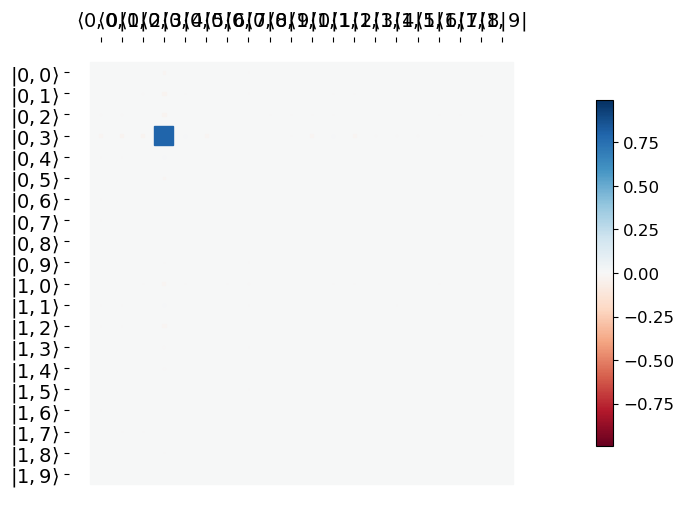

In [6]:
H = create_hamiltonian(1)
rho0 = qt.tensor(qt.basis(dim_qubit, 0), qt.fock(dim_phonon, 0))
rhot = qt.tensor(qt.basis(dim_qubit, 0), qt.basis(dim_phonon, target_fock))
sim_res = simulate_hamiltonian(H,rho0, c_ops = [])
print(f"Fidelity : {qt.fidelity(sim_res[-1], rhot)}")
tt, gg, ee, g0, g1, e0, e1 = compute_dm(sim_res)

### Calculate Fidelity and Plot Density Matrix (@ Pulse Prep)

10.0%. Run time:   0.04s. Est. time left: 00:00:00:00
20.0%. Run time:   0.08s. Est. time left: 00:00:00:00
30.0%. Run time:   0.13s. Est. time left: 00:00:00:00
40.0%. Run time:   0.17s. Est. time left: 00:00:00:00
50.0%. Run time:   0.22s. Est. time left: 00:00:00:00
60.0%. Run time:   0.26s. Est. time left: 00:00:00:00
70.0%. Run time:   0.30s. Est. time left: 00:00:00:00
80.0%. Run time:   0.35s. Est. time left: 00:00:00:00
90.0%. Run time:   0.39s. Est. time left: 00:00:00:00
Total run time:   0.43s
mesolve time: 0.4s
Fidelity : 0.9102633666286732


100%|██████████| 211/211 [00:00<00:00, 656.44it/s]


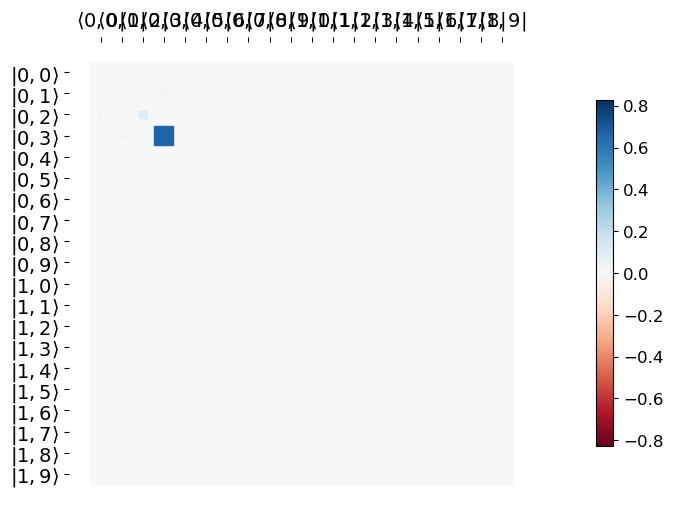

In [7]:
H = create_hamiltonian(1)
rho0 = qt.tensor(qt.basis(dim_qubit, 0), qt.fock(dim_phonon, 0))
rhot = qt.tensor(qt.basis(dim_qubit, 0), qt.basis(dim_phonon, target_fock))
sim_res = simulate_hamiltonian(H,rho0)
print(f"Fidelity : {qt.fidelity(sim_res[-1], rhot)}")
tt, gg, ee, g0, g1, e0, e1 = compute_dm(sim_res)

### Plot Average Population in Phonon Mode (@ Pulse Prep)

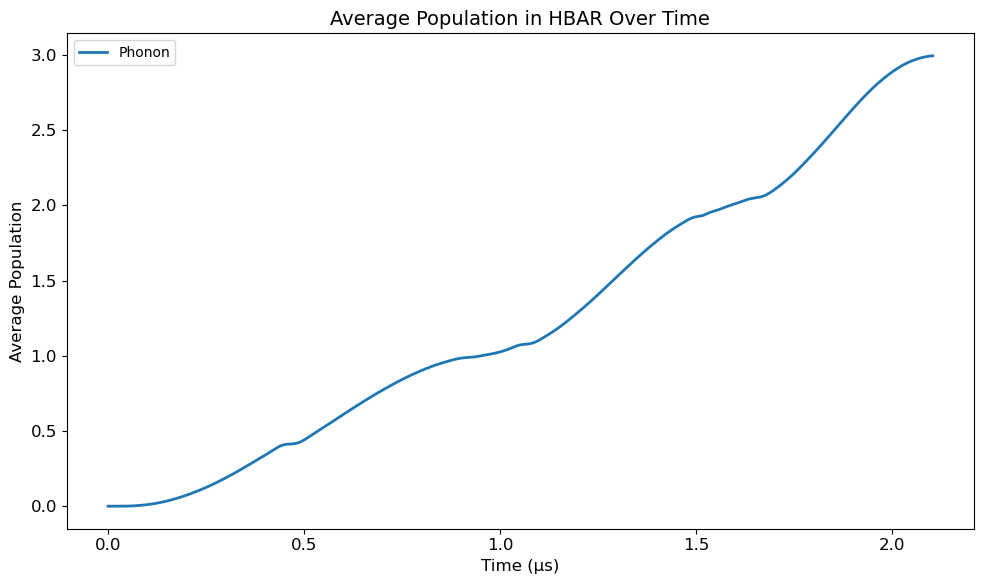

In [8]:
# Number operator for the phonon mode
n_r = qt.tensor(qt.qeye(dim_qubit), qt.num(dim_phonon))

H_tot = create_hamiltonian(1)
result = qt.mesolve(H_tot, rho0, times_1, [], e_ops=[n_r])
plt.figure(figsize=(10, 6))
plt.plot(times_1, result.expect[0], lw=2, label='Phonon')
plt.xlabel('Time (μs)', fontsize=12)
plt.ylabel('Average Population', fontsize=12)
plt.title(f'Average Population in HBAR Over Time', fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

### Plot Wigner Function (@ Pulse Prep)

10.0%. Run time:   0.04s. Est. time left: 00:00:00:00
20.0%. Run time:   0.08s. Est. time left: 00:00:00:00
30.0%. Run time:   0.13s. Est. time left: 00:00:00:00
40.0%. Run time:   0.16s. Est. time left: 00:00:00:00
50.0%. Run time:   0.21s. Est. time left: 00:00:00:00
60.0%. Run time:   0.26s. Est. time left: 00:00:00:00
70.0%. Run time:   0.30s. Est. time left: 00:00:00:00
80.0%. Run time:   0.35s. Est. time left: 00:00:00:00
90.0%. Run time:   0.39s. Est. time left: 00:00:00:00
Total run time:   0.43s
mesolve time: 0.4s


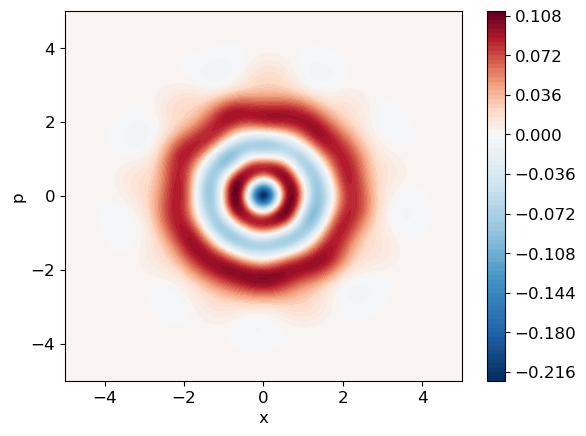

In [9]:
sim_res = simulate_hamiltonian(H,rho0)
final_state = sim_res[-1]

# Plot the Wigner function of the final state
xvec = np.linspace(-5, 5, 200)
W = qt.wigner(final_state, xvec, xvec)
fig, ax = plt.subplots()
norm = TwoSlopeNorm(vmin=W.min(), vcenter=0, vmax=W.max())
cont = ax.contourf(xvec, xvec, W, 100, cmap='RdBu_r', norm=norm)
cb = fig.colorbar(cont)
ax.set_xlabel('x')
ax.set_ylabel('p')
ax.set_title('')
plt.show()

### Simulate On-Resonance Rabi Oscillations (@ Measurement Time)

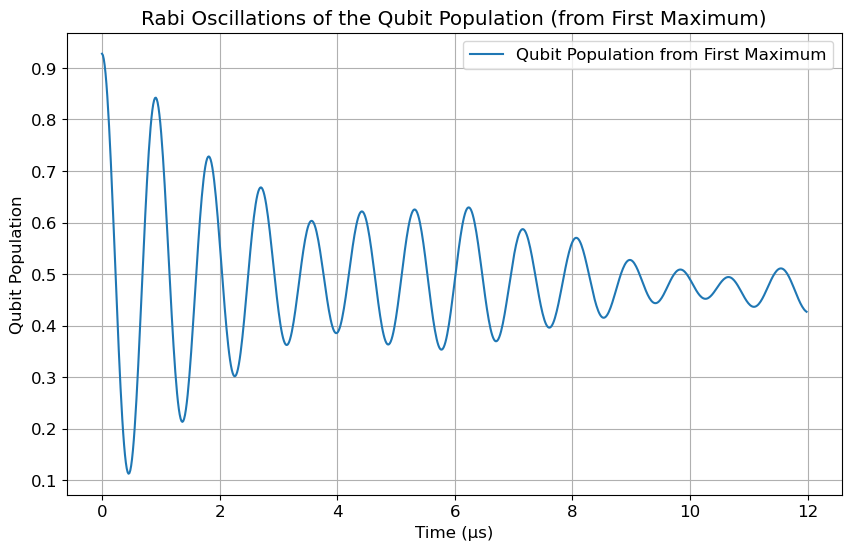

In [10]:
# Trace out the qubit from the final state to get the cavity state
cavity_state = final_state.ptrace(1) 

# Tensor the cavity state with a qubit in the excited state
excited_qubit_dm = qt.ket2dm(qt.basis(dim_qubit, 1))
final_state = qt.tensor(excited_qubit_dm, cavity_state)

Hcoupling = ga * (pd * q + p * qd)

# Time array 
times_3 = np.linspace(0, 15, 1000)

# Evolve the state with the Hamiltonian
result = qt.mesolve(Hcoupling, final_state, times_3, [np.sqrt(g1p) * p, np.sqrt(g1q) * q, np.sqrt(2 * gphiq) * qd * q], [qd * q])

# Extract qubit population
qubit_pop = result.expect[0]
peaks, _ = find_peaks(qubit_pop)
first_peak_idx = peaks[0] if len(peaks) > 0 else 0

# Extract the data from the first maximum onward until the measurement time
tlist_from_peak = times_3[first_peak_idx:first_peak_idx + int(12 / (times_3[1] - times_3[0]))]
qubit_pop_from_peak = qubit_pop[first_peak_idx:first_peak_idx + int(12 / (times_3[1] - times_3[0]))]
tlist_from_peak = tlist_from_peak - times_3[first_peak_idx]

# Plot the Rabi oscillations from the first maximum onward
plt.figure(figsize=(10, 6))
plt.plot(tlist_from_peak, qubit_pop_from_peak, label='Qubit Population from First Maximum')
plt.xlabel('Time (μs)')
plt.ylabel('Qubit Population')
plt.title('Rabi Oscillations of the Qubit Population (from First Maximum)')
plt.legend()
plt.grid(True)
plt.show()

# Store the data in an HDF5 file
h5filename = '20011122_optimal_control.h5'
file_name = '20011122_999999'

with h5py.File(h5filename, 'w') as f:
    grp = f.create_group(file_name)
    grp.create_dataset('xdata', data=tlist_from_peak)
    grp.create_dataset('ydata', data=qubit_pop_from_peak)

### Calculate Fidelity During Free Evolution After Pulse Prep

In [11]:
H = create_hamiltonian(1)
sim_res = simulate_hamiltonian(H,rho0)
final_state = sim_res[-1]
c_ops = [np.sqrt(g1p) * p]
H = p.dag() * p * 0
times_2 = np.linspace(0, 10, 1000)
result = qt.mesolve(H, final_state, times_2, c_ops)
final_state = result.states[-1]

print(f"Fidelity : {qt.fidelity(rhot, final_state)}")

10.0%. Run time:   0.05s. Est. time left: 00:00:00:00
20.0%. Run time:   0.09s. Est. time left: 00:00:00:00
30.0%. Run time:   0.14s. Est. time left: 00:00:00:00
40.0%. Run time:   0.19s. Est. time left: 00:00:00:00
50.0%. Run time:   0.24s. Est. time left: 00:00:00:00
60.0%. Run time:   0.29s. Est. time left: 00:00:00:00
70.0%. Run time:   0.34s. Est. time left: 00:00:00:00
80.0%. Run time:   0.39s. Est. time left: 00:00:00:00
90.0%. Run time:   0.43s. Est. time left: 00:00:00:00
Total run time:   0.48s
mesolve time: 0.5s
Fidelity : 0.43065555449506404
